In [67]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

# Prepare Dataset

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),])

trainset = datasets.MNIST('/.data', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

# Split datasets

In [62]:
valid_size = 0.2
num_train = len(trainset)
indices = list(range(num_train))

In [59]:
np.random.shuffle(indices)

In [64]:
split = int(np.floor(valid_size * num_train))

In [65]:
train_idx, valid_idx = indices[split:], indices[:split]

In [68]:
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [72]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64,
    sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(trainset, batch_size=64, 
    sampler=valid_sampler)

In [75]:
len(train_loader), len(valid_loader)

(750, 188)

# Visualize

In [4]:
data = next(iter(trainloader))
images, labels = data

In [5]:
print(images[0].shape)
print(np.squeeze(images[0]).shape)

torch.Size([1, 28, 28])
torch.Size([28, 28])


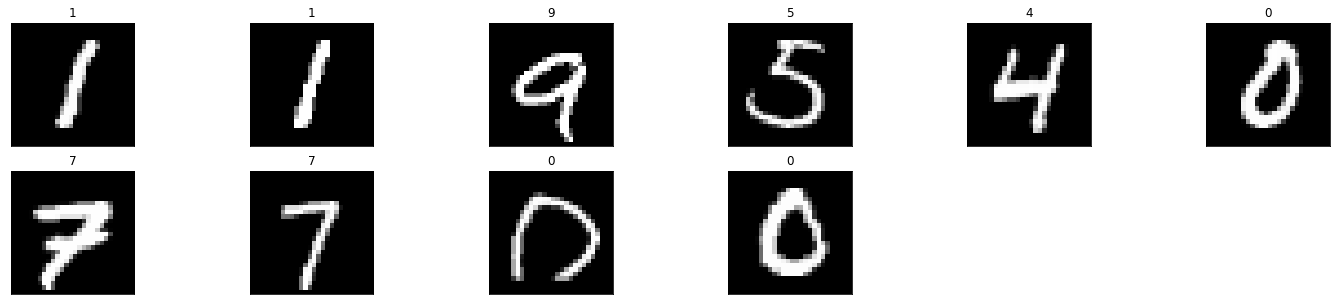

In [6]:
fig = plt.figure(figsize=(25, 5))

for i in range(10):
    ax = fig.add_subplot(2, 6, i+1, xticks=[], yticks=[])
    img = images[i]
    img = np.squeeze(img)
    ax.imshow(img, cmap='gray')
    ax.set_title(str(labels[i].item()))

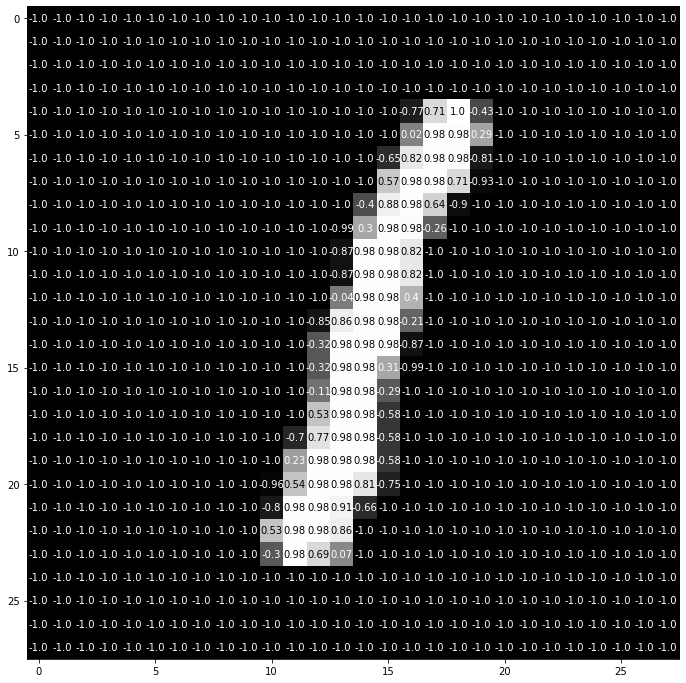

In [7]:
img = np.squeeze(images[0]).numpy()

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

# Define Model

In [8]:
from torch import nn

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = nn.Linear(28 * 28, 512)
        self.layer2 = nn.Linear(512, 128)
        self.layer3 = nn.Linear(128, 10)
        self.drop = nn.Dropout(p=0.2)

    def forward(self, x):
        # Flatten
        x = x.view(x.shape[0], -1)
        x = self.drop(F.relu(self.layer1(x)))
        x = self.drop(F.relu(self.layer2(x)))
        x = self.layer3(x)
        return F.log_softmax(x, dim=1)


# Network Summery

In [9]:
from torchsummary import summary

# create model
model = Net()
# print summery
summary(model, (28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         401,920
           Dropout-2                  [-1, 512]               0
            Linear-3                  [-1, 128]          65,664
           Dropout-4                  [-1, 128]               0
            Linear-5                   [-1, 10]           1,290
Total params: 468,874
Trainable params: 468,874
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.79
Estimated Total Size (MB): 1.80
----------------------------------------------------------------


# Hyper Parameters

In [10]:
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train Network

In [11]:
data = next(iter(trainloader))
images, labels = data

## Forward pass

In [12]:
output = model(images)
output[:2][:2]

tensor([[-2.4110, -2.3186, -1.9857, -2.4245, -2.4222, -2.1606, -2.3997, -2.3359,
         -2.2931, -2.3681],
        [-2.3394, -2.3343, -2.0973, -2.3586, -2.2537, -2.2366, -2.2723, -2.3627,
         -2.4703, -2.3460]], grad_fn=<SliceBackward>)

## Calculate Error

In [13]:
loss = criterion(output, labels)
loss

tensor(2.2838, grad_fn=<NllLossBackward>)

## Backpropagation

In [14]:
loss.backward()

## Update weights

In [15]:
optimizer.step()

## Print Loss

In [16]:
loss.item()

2.28383207321167

# How to calculate Accuracy

## Take maximum values from every tensor

In [17]:
torch.max(output, dim=1)

torch.return_types.max(
values=tensor([-1.9857, -2.0973, -2.1466, -2.1373, -2.1550, -2.1457, -2.0721, -2.0679,
        -2.0060, -2.1589, -2.1576, -2.0168, -2.0124, -2.1410, -2.1586, -2.0852,
        -2.1747, -2.0532, -2.1895, -2.1686, -2.1450, -2.1115, -2.1171, -2.0960,
        -1.9956, -2.1340, -2.0516, -2.1259, -2.0122, -2.0634, -2.1828, -2.1154],
       grad_fn=<MaxBackward0>),
indices=tensor([2, 2, 6, 6, 2, 6, 2, 5, 2, 5, 2, 6, 2, 6, 2, 2, 6, 2, 2, 2, 6, 2, 2, 2,
        2, 5, 6, 2, 2, 2, 2, 2]))

## Save labels only

In [18]:
_, prediction = torch.max(output, dim=1)
prediction

tensor([2, 2, 6, 6, 2, 6, 2, 5, 2, 5, 2, 6, 2, 6, 2, 2, 6, 2, 2, 2, 6, 2, 2, 2,
        2, 5, 6, 2, 2, 2, 2, 2])

## Compare predicted labels with true labels

In [19]:
prediction == labels

tensor([False, False, False, False,  True, False, False, False, False, False,
         True, False, False,  True, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
         True, False])

In [20]:
correct = (prediction == labels).sum().item()
correct

5

In [21]:
total = labels.size(0)
total

32

## Accuracy

In [22]:
(correct / total) * 100

15.625

# Another way

In [23]:
ps = torch.exp(output)
ps[:2][:2]

tensor([[0.0897, 0.0984, 0.1373, 0.0885, 0.0887, 0.1153, 0.0907, 0.0967, 0.1010,
         0.0937],
        [0.0964, 0.0969, 0.1228, 0.0946, 0.1050, 0.1068, 0.1031, 0.0942, 0.0846,
         0.0958]], grad_fn=<SliceBackward>)

## Take all the top labels

In [24]:
_, top_class = ps.topk(1, dim=1)

## compare this predicted labels with true labels

In [25]:
top_class == labels

tensor([[False, False, False,  ..., False,  True, False],
        [False, False, False,  ..., False,  True, False],
        [False, False, False,  ...,  True, False, False],
        ...,
        [False, False, False,  ..., False,  True, False],
        [False, False, False,  ..., False,  True, False],
        [False, False, False,  ..., False,  True, False]])

In [26]:
equals = top_class == labels.view(*top_class.shape)

## Convert into float tensor

In [27]:
equals.type(torch.FloatTensor);

## Calculate Mean

In [28]:
acc = torch.mean(equals.type(torch.FloatTensor)).item()

In [29]:
acc * 100

15.625

## See, both way produce same results

# Calculate accuracy class wise

In [35]:
total_class = 10
class_correct = list(0. for i in range(total_class))
class_total = list(0. for i in range(total_class))

## Get prediction

In [36]:
_, pred = torch.max(output, 1)

## Compare with actual labels

In [39]:
correct = pred == labels

## Calculate class wise

In [46]:
for i in range(len(labels) - 1):
    label = labels.data[i]
    class_correct[label] += correct[i].item()
    class_total[label] += 1

In [47]:
class_correct

[0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]

In [48]:
class_total

[1.0, 4.0, 4.0, 7.0, 1.0, 1.0, 5.0, 4.0, 2.0, 2.0]

In [51]:
class_correct[0]/class_total[0]

0.0

## For every class

In [49]:
for i in range(total_class):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

Test Accuracy of     0:  0% ( 0/ 1)
Test Accuracy of     1:  0% ( 0/ 4)
Test Accuracy of     2: 100% ( 4/ 4)
Test Accuracy of     3:  0% ( 0/ 7)
Test Accuracy of     4:  0% ( 0/ 1)
Test Accuracy of     5:  0% ( 0/ 1)
Test Accuracy of     6: 20% ( 1/ 5)
Test Accuracy of     7:  0% ( 0/ 4)
Test Accuracy of     8:  0% ( 0/ 2)
Test Accuracy of     9:  0% ( 0/ 2)
